In [1]:
#Python-related imports
from datetime import datetime
import os.path

#PyData imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import bisect
from torch.autograd import Function

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from TruncatedNormal import *

In [3]:
torch.manual_seed(0)
np.random.seed(0)

torch.set_printoptions(precision = 8)

In [4]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    #print(x.stddev - target_sd)
    return x.stddev - target_sd

In [5]:
SAWB_ECA_SS_priors_details = {k: v for k, v in torch.load(os.path.join('generated_data/', 'SAWB-ECA-SS_CO2_trunc_short_2021_12_24_12_46_sample_y_t_2000_dt_0-01_sd_scale_0-25_hyperparams.pt')).items()}
print(SAWB_ECA_SS_priors_details)
stochastic_parameters = ['s_SOC', 's_DOC', 's_MBC', 's_EEC']
SAWB_ECA_SS_priors_details = dict([(k, v) for k, v in SAWB_ECA_SS_priors_details.items() if k not in stochastic_parameters])
print(SAWB_ECA_SS_priors_details)

keys = list(SAWB_ECA_SS_priors_details.keys())

prior_list = list(zip(*(SAWB_ECA_SS_priors_details[k] for k in list(SAWB_ECA_SS_priors_details.keys()))))
prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list)
p_theta = TruncatedNormal(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

lower = prior_lowers_tensor
upper = prior_uppers_tensor

{'u_Q_ref': tensor([0.22000000, 0.05500000, 0.00000000, 1.00000000]), 'Q': tensor([0.00100000, 0.00025000, 0.00000000, 0.10000000]), 'a_MSA': tensor([0.50000000, 0.12500000, 0.00000000, 1.00000000]), 'K_DE': tensor([1000.,  250.,    0., 5000.]), 'K_UE': tensor([0.10000000, 0.02500000, 0.00000000, 1.00000000]), 'V_DE_ref': tensor([0.04000000, 0.01000000, 0.00000000, 1.00000000]), 'V_UE_ref': tensor([0.00500000, 0.00125000, 0.00000000, 0.10000000]), 'Ea_V_DE': tensor([40., 10.,  5., 80.]), 'Ea_V_UE': tensor([30.00000000,  7.50000000,  5.00000000, 80.00000000]), 'r_M': tensor([1.66669997e-04, 4.16674993e-05, 0.00000000e+00, 1.00000001e-01]), 'r_E': tensor([1.99999995e-04, 4.99999987e-05, 0.00000000e+00, 1.00000001e-01]), 'r_L': tensor([3.99999990e-04, 9.99999975e-05, 0.00000000e+00, 1.00000001e-01]), 's_SOC': tensor([9.99999975e-05, 2.49999994e-05, 0.00000000e+00, 1.00000001e-01]), 's_DOC': tensor([9.99999975e-05, 2.49999994e-05, 0.00000000e+00, 1.00000001e-01]), 's_MBC': tensor([9.999999

In [6]:
true_theta = torch.load(os.path.join('generated_data/', 'SAWB-ECA-SS_CO2_trunc_short_2021_12_24_12_46_sample_y_t_2000_dt_0-01_sd_scale_0-25_rsample.pt'))
print(true_theta)

{'u_Q_ref': array(0.2194861, dtype=float32), 'Q': array(0.00118326, dtype=float32), 'a_MSA': array(0.33124655, dtype=float32), 'K_DE': array(720.8212, dtype=float32), 'K_UE': array(0.08742235, dtype=float32), 'V_DE_ref': array(0.04342706, dtype=float32), 'V_UE_ref': array(0.00496901, dtype=float32), 'Ea_V_DE': array(52.615257, dtype=float32), 'Ea_V_UE': array(29.16851, dtype=float32), 'r_M': array(0.00018075, dtype=float32), 'r_E': array(0.00018059, dtype=float32), 'r_L': array(0.00037511, dtype=float32), 's_SOC': array(4.9816543e-05, dtype=float32), 's_DOC': array(7.603552e-05, dtype=float32), 's_MBC': array(8.645011e-05, dtype=float32), 's_EEC': array(0.00010116, dtype=float32)}


In [7]:
df = pd.read_csv(os.path.join('NUTS_results/', 'AWB-ECA_CO2_NUTS_inference_SDE_data_theta_post.csv'))
df_post = df.loc[:, 'u_Q_ref':'r_L']
print(df_post)

       u_Q_ref         Q     a_MSA     K_DE      K_UE  V_DE_ref  V_UE_ref  \
0     0.242498  0.001936  0.479942  531.582  0.067840  0.039263  0.005707   
1     0.240478  0.002011  0.589958  485.652  0.058341  0.036026  0.005651   
2     0.236136  0.002143  0.458378  788.176  0.059225  0.050277  0.005682   
3     0.234227  0.001705  0.525757  927.748  0.062996  0.060913  0.005790   
4     0.233850  0.002453  0.444807  571.494  0.069518  0.039189  0.005580   
...        ...       ...       ...      ...       ...       ...       ...   
4995  0.230362  0.002092  0.544698  705.517  0.029307  0.048341  0.005558   
4996  0.231435  0.001997  0.511623  759.903  0.024809  0.047235  0.005688   
4997  0.233986  0.001857  0.391371  847.093  0.089828  0.053336  0.005716   
4998  0.239274  0.002261  0.543661  444.969  0.024537  0.032563  0.005589   
4999  0.241632  0.002248  0.551695  470.903  0.026103  0.034624  0.005580   

      Ea_V_DE  Ea_V_UE       r_M       r_E       r_L  
0     35.5896  24.47

<AxesSubplot:xlabel='u_Q_ref', ylabel='Density'>

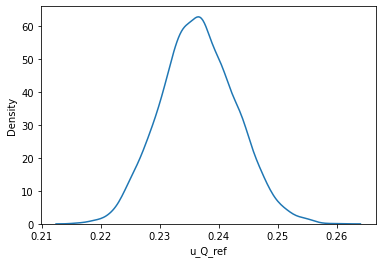

In [8]:
sns.kdeplot(data = df_post, x = "u_Q_ref")

In [9]:
x0 = torch.max(p_theta.mean - 4 * p_theta.stddev, lower).detach()
x1 = torch.min(p_theta.mean + 4 * p_theta.stddev, upper).detach()

print(x0)
print(x1)

num_pts = 10000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(p_theta.log_prob(x)).detach()

tensor([6.62505627e-05, 3.01166438e-07, 2.67744064e-04, 3.01147461e-01,
        3.01152468e-05, 1.20438635e-05, 1.50548294e-06, 5.00000000e+00,
        5.00000000e+00, 5.01895556e-08, 6.02303771e-08, 1.20460754e-07])
tensor([4.39948469e-01, 1.99976563e-03, 9.99732256e-01, 1.99976575e+03,
        1.99976578e-01, 7.99906254e-02, 9.99882817e-03, 7.99355011e+01,
        5.99342880e+01, 3.33300966e-04, 3.99953162e-04, 7.99906324e-04])


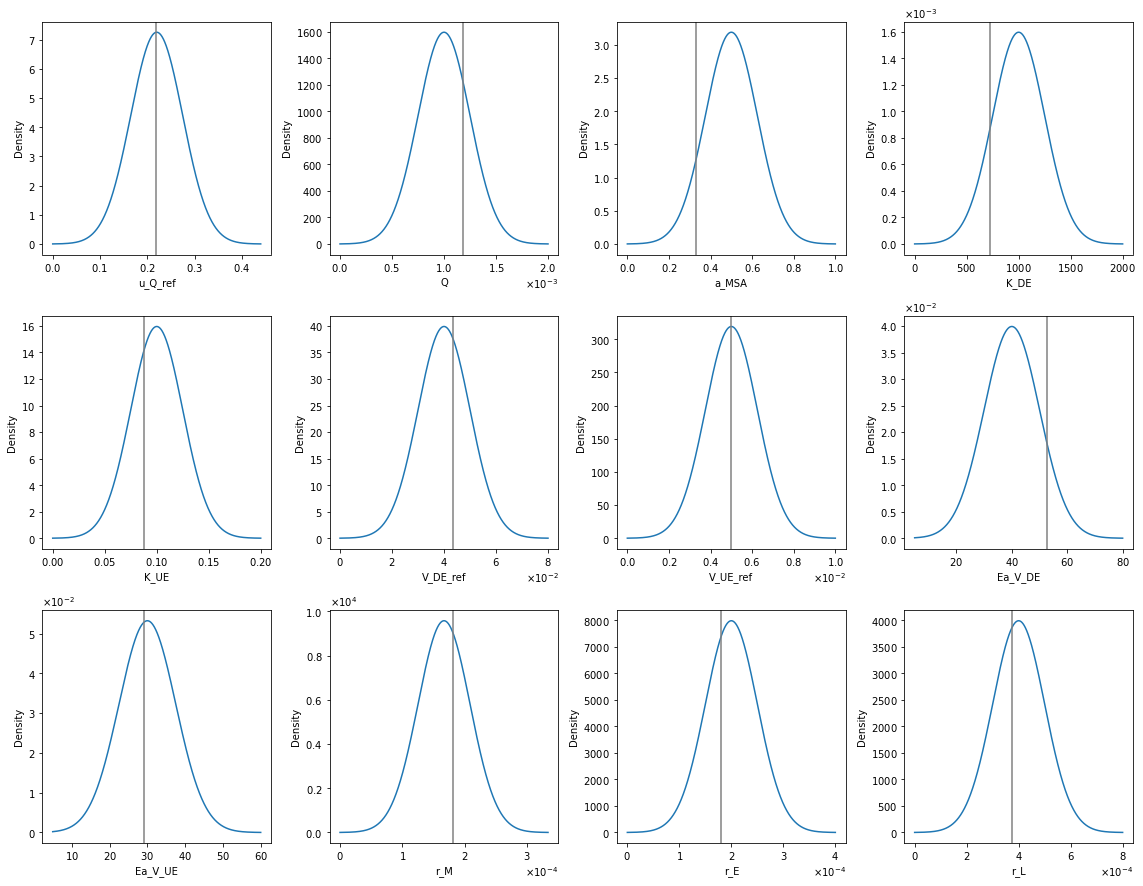

In [10]:
num_params = len(SAWB_ECA_SS_priors_details)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < num_params:
            key = keys[k]
            ax.plot(x[:, k], pdf[:, k])
            ax.axvline(true_theta[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('Density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()

In [11]:
#Create approximate posterior q_dist to facilitate plotting of posterior KDE densities.

#Parameter posterior summary means
u_Q_ref_mean = 0.236528036
Q_mean = 0.002081792126
a_MSA_mean = 0.49459766288
K_DE_mean = 697.80063553396
K_UE_mean = 0.0508024329368
V_DE_ref_mean = 0.046546898044
V_UE_ref_mean = 0.005690686176
Ea_V_DE_mean = 41.02682276
Ea_V_UE_mean = 24.0657701
r_M_mean = 0.00003081253327352
r_E_mean = 0.0003804674824
r_L_mean = 0.0003569254862

#Parameter posterior summary sds
u_Q_ref_sd = 0.00634961092823067
Q_sd = 0.000241592155579993
a_MSA_sd = 0.119772750485448
K_DE_sd = 163.944516660051
K_UE_sd = 0.0238438416007499
V_DE_sd = 0.00919466033638822
V_UE_sd = 0.0000816179245353501
Ea_V_DE_sd = 2.29457309421053
Ea_V_UE_sd = 0.669122329277911
r_M_sd = 0.0000239196771006517
r_E_sd = 0.0000284428307190538
r_L_sd = 0.0000357801724390557

#SCON theta logit-normal distribution parameter details in order of mean, sdev, lower, and upper.
u_Q_ref_details = torch.Tensor([u_Q_ref_mean, u_Q_ref_sd, 0, 1])
Q_details = torch.Tensor([Q_mean, Q_sd, 0, 0.1])
a_MSA_details = torch.Tensor([a_MSA_mean, a_MSA_sd, 0, 1])
K_DE_details = torch.Tensor([K_DE_mean, K_DE_sd, 0, 5000])
K_UE_details = torch.Tensor([K_UE_mean, K_UE_sd, 0, 1])
V_DE_ref_details = torch.Tensor([V_DE_ref_mean, V_DE_sd, 0, 1])
V_UE_ref_details = torch.Tensor([V_UE_ref_mean, V_UE_sd, 0, 0.1])
Ea_V_DE_details = torch.Tensor([Ea_V_DE_mean, Ea_V_DE_sd, 5, 80])
Ea_V_UE_details = torch.Tensor([Ea_V_UE_mean, Ea_V_UE_sd, 5, 80])
r_M_details = torch.Tensor([r_M_mean, r_M_sd, 0, 0.1])
r_E_details = torch.Tensor([r_E_mean, r_E_sd, 0, 0.1])
r_L_details = torch.Tensor([r_L_mean, r_L_sd, 0, 0.1])

SAWB_ECA_SS_posteriors_dict = {'u_Q_ref': u_Q_ref_details, 'Q': Q_details, 'a_MSA': a_MSA_details, 'K_DE': K_DE_details, 'K_UE': K_UE_details, 'V_DE_ref': V_DE_ref_details, 'V_UE_ref': V_UE_ref_details, 'Ea_V_DE': Ea_V_DE_details, 'Ea_V_UE': Ea_V_UE_details, 'r_M': r_M_details, 'r_E': r_E_details, 'r_L': r_L_details}

In [12]:
keys_post = list(SAWB_ECA_SS_posteriors_dict.keys())
loc_post, scale_post, a_post, b_post = torch.tensor(list(zip(*(SAWB_ECA_SS_posteriors_dict[k] for k in keys_post))))
print(loc_post, scale_post, a_post, b_post)
q_theta = TruncatedNormal(loc_post, scale_post, a_post, b_post)

tensor([2.36528039e-01, 2.08179210e-03, 4.94597673e-01, 6.97800659e+02,
        5.08024320e-02, 4.65468988e-02, 5.69068640e-03, 4.10268211e+01,
        2.40657692e+01, 3.08125345e-05, 3.80467478e-04, 3.56925477e-04]) tensor([6.34961110e-03, 2.41592163e-04, 1.19772747e-01, 1.63944519e+02,
        2.38438416e-02, 9.19466000e-03, 8.16179236e-05, 2.29457307e+00,
        6.69122338e-01, 2.39196779e-05, 2.84428315e-05, 3.57801728e-05]) tensor([0., 0., 0., 0., 0., 0., 0., 5., 5., 0., 0., 0.]) tensor([1.00000000e+00, 1.00000001e-01, 1.00000000e+00, 5.00000000e+03,
        1.00000000e+00, 1.00000000e+00, 1.00000001e-01, 8.00000000e+01,
        8.00000000e+01, 1.00000001e-01, 1.00000001e-01, 1.00000001e-01])


In [13]:
x0 = torch.min(q_theta.mean - 4 * q_theta.stddev, p_theta.mean - 4 * p_theta.stddev)
x0 = torch.max(x0, lower).detach()

x1 = torch.max(q_theta.mean + 4 * q_theta.stddev, p_theta.mean + 4 * p_theta.stddev)
x1 = torch.min(x1, upper).detach()

print(x0)
print(x1)

num_pts = 1000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf_prior = torch.exp(p_theta.log_prob(x)).detach()
pdf_post = torch.exp(q_theta.log_prob(x)).detach()

tensor([6.62505627e-05, 3.01166438e-07, 2.67744064e-04, 3.01147461e-01,
        0.00000000e+00, 1.20438635e-05, 1.50548294e-06, 5.00000000e+00,
        5.00000000e+00, 0.00000000e+00, 6.02303771e-08, 1.20460754e-07])
tensor([4.39948469e-01, 3.04816081e-03, 9.99732256e-01, 1.99976575e+03,
        1.99976578e-01, 8.33254457e-02, 9.99882817e-03, 7.99355011e+01,
        5.99342880e+01, 3.33300966e-04, 4.94238804e-04, 7.99906324e-04])


In [14]:
plt.rcParams['text.usetex'] = True

In [15]:
theta_latex_strings = ['$u_{Q,\\: \\textrm{ref}}$', '$Q$', '$a_{MSA}$', '$K_{DE}$', '$K_{UE}$', '$V_{DE,\\: \\textrm{ref}}$', '$V_{UE,\\: \\textrm{ref}}$', '$Ea_{V_{DE}}$', '$Ea_{V_{UE}}$', '$r_M$', '$r_E$', '$r_L$']
print(theta_latex_strings)

['$u_{Q,\\: \\textrm{ref}}$', '$Q$', '$a_{MSA}$', '$K_{DE}$', '$K_{UE}$', '$V_{DE,\\: \\textrm{ref}}$', '$V_{UE,\\: \\textrm{ref}}$', '$Ea_{V_{DE}}$', '$Ea_{V_{UE}}$', '$r_M$', '$r_E$', '$r_L$']


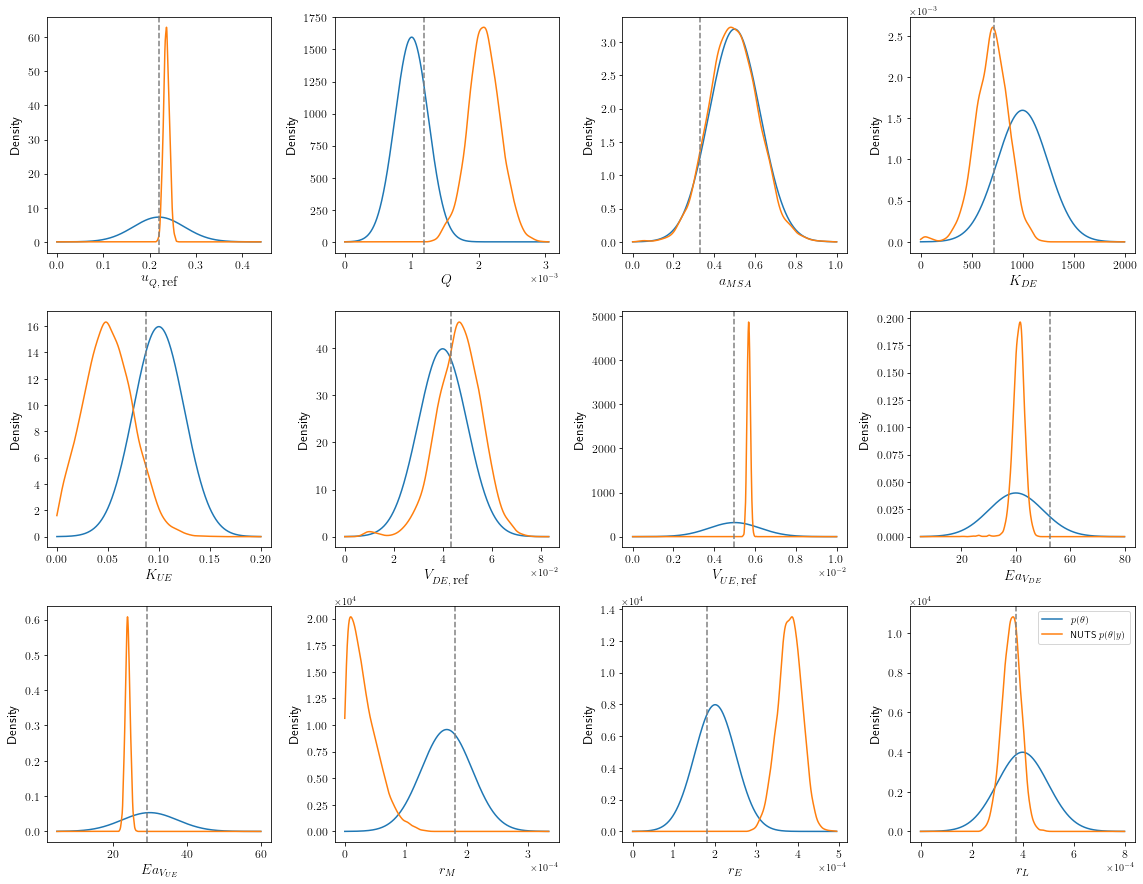

In [16]:
num_params = len(SAWB_ECA_SS_priors_details)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < num_params:
            theta_name = theta_latex_strings[k]
            key = keys[k]
            post_kde_density = stats.gaussian_kde(df_post.loc[:, key])
            ax.plot(x[:, k], pdf_prior[:, k], label = r'$p(\theta)$')
            ax.plot(x[:, k], post_kde_density(x[:, k]), label = r'NUTS $p(\theta | y)$')
            ax.axvline(true_theta[key], color='gray', linestyle = '--')
            ax.set_xlabel(theta_name, fontsize = 14)
            ax.set_ylabel('Density', fontsize = 13, labelpad = 6)
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
            ax.tick_params(axis='both', labelsize = 12)
        else:
            fig.delaxes(axes[i, j])
        k += 1
plt.legend()
plt.subplots_adjust(hspace = .001)
plt.tight_layout()

In [17]:
fig.savefig('AWB-ECA_NUTS_prior_post.pdf', dpi = 350)